# 05 :: UMAP embedding of the spots

In [1]:
# %load common.py
import pandas as pd
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Commonly used constants.

slides = [
    'B02_D1', 'B02_E1', 'B03_C2', 'B03_D2', 'B04_D1',
    'B04_E1', 'B05_D2', 'B05_E2', 'B06_E1', 'B07_C2',
    'N02_C1', 'N02_D1', 'N03_C2', 'N03_D2', 'N04_D1',
    'N04_E1', 'N05_C2', 'N05_D2', 'N06_D2', 'N07_C1']

GT = 'GT'
YEN = 'AB1_StdDev_Yen'
REGION = 'Region_predict'
ASTROCYTE = 'astrocyte'
NEURON = 'neuron'
INTERNEURON = 'interneuron'
AGE = 'age'
DAYS = 'age_days'
MONTHS = 'age_months'
AGE_GT ='age_GT'
SAMPLE_ID = 'sampleID'
SPOT_UID = 'spot_UID'
SLIDE_ID = 'slide_ID'

# The merged data file in Parquet format.

parquet = '/media/tmo/data/work/datasets/02_ST/parquet/'
st_full = parquet + 'st_full'

def read_full(path=st_full):
    return pd.read_parquet(st_full)

def enrich(full):
    # Add age column (young, old)
    full[AGE] = np.where(full[MONTHS] < 10, 'young', 'old')
    
    # Add combined column age_GT.
    full[AGE_GT] = full[[AGE, GT]].apply(lambda x: '_'.join(x), axis=1)
    
    # parse slide ID
    full['slide_ID'] = full[SPOT_UID].apply(lambda x: str(x).split('__')[0])
    
    return full

def read_enriched(path=st_full):
    return enrich(read_full(path))
    
# TODO
# * add 'coarse_region' that joins regions with <500 entries in them into one region OTHER

In [2]:
from umap import UMAP

* **TODO** clean up categorical data in a better way

In [3]:
full = read_enriched()

In [4]:
slide_id2nr_map = dict(zip(list(full['slide_ID'].unique()), range(0,20)))

full['slide_nr'] = full[SLIDE_ID].apply(lambda x: slide_id2nr_map[x] )

In [5]:
n_genes = 46454

In [6]:
gene_cols = full.columns[1:n_genes+1]

In [7]:
ex_matrix = full[gene_cols].as_matrix()

In [8]:
ex_matrix.shape

(10327, 46454)

In [9]:
ex_matrix_KI = full[full['GT'] == 'KI'][gene_cols].as_matrix()

In [10]:
full['GT'] = full['GT'].astype('category', copy=False)
full['GT'].dtype

CategoricalDtype(categories=['KI', 'WT'], ordered=False)

In [11]:
full[AGE_GT] = full[AGE_GT].astype('category', copy=False)
full[AGE_GT].dtype

CategoricalDtype(categories=['old_KI', 'old_WT', 'young_KI', 'young_WT'], ordered=False)

In [12]:
full[AGE] = full[AGE].astype('category', copy=False)
full[AGE].dtype

CategoricalDtype(categories=['old', 'young'], ordered=False)

---

### Genes ranked by leverage
* read from .tsv file

In [13]:
ranked_gene_lev_df = pd.read_csv('ranked_gene_leverage.tsv', sep='\t', index_col=0)

In [14]:
ranked_gene_lev_df.head()

,gene,leverage
18440,Gm26228,0.039117
23867,Gm44074,0.035930
15575,Gm21956,0.035028
32402,Mir8105,0.034804
43965,Trim50,0.033270


In [15]:
lev_ranked_genes = ranked_gene_lev_df.gene.values

In [16]:
lev_ranked_genes[:5]

array(['Gm26228', 'Gm44074', 'Gm21956', 'Mir8105', 'Trim50'], dtype=object)

---

In [25]:
ex_matrix_lev_25 = full[lev_ranked_genes[:25]]
ex_matrix_lev_50 = full[lev_ranked_genes[:50]]
ex_matrix_lev_100 = full[lev_ranked_genes[:100]]
ex_matrix_lev_500 = full[lev_ranked_genes[:500]]
ex_matrix_lev_1000 = full[lev_ranked_genes[:1000]]

---

* unfortunately, UMAP is single-threaded
* running time @ 2.2Ghz, 1 cpu = 1h55
* cause of bad performance is high dimensionality
* https://matplotlib.org/examples/color/colormaps_reference.html

In [18]:
full.columns

In [19]:
def umap_minkowski(ex_matrix):
    return UMAP(n_neighbors=5,
                min_dist=0.3, 
                spread=1,
                random_state=666,
                metric='minkowski',
                metric_kwds={'p': 0.5}).fit_transform(ex_matrix)

In [63]:
def plot_embedding(umap_embedding):
    embedding_df = pd.DataFrame(umap_embedding, columns=['x', 'y'])
    
    fig, axes = plt.subplots(2, 2, figsize=(28, 24))
    
    g1 = embedding_df.plot.scatter(ax=axes[0][0], x='x', y='y', alpha=1, c=full[GT].cat.codes, cmap=plt.cm.get_cmap('tab20', 2))
    g2 = embedding_df.plot.scatter(ax=axes[0][1], x='x', y='y', alpha=1, c=full[AGE].cat.codes, cmap=plt.cm.get_cmap('Set1', 2))
    g3 = embedding_df.plot.scatter(ax=axes[1][0], x='x', y='y', alpha=1, c=full[AGE_GT].cat.codes, cmap=plt.cm.get_cmap('tab20', 4))
    g4 = embedding_df.plot.scatter(ax=axes[1][1], x='x', y='y', alpha=0.5, c=full['slide_nr'].values, cmap=plt.cm.get_cmap('tab20'))
    
    for g in [g1, g2, g3, g4]:
        g.grid(False)
    
    plt.show()

In [20]:
%%time
umap_lev_25_minkowski = umap_minkowski(ex_matrix_lev_25)

CPU times: user 59.8 s, sys: 17.9 s, total: 1min 17s
Wall time: 28.4 s


In [21]:
%%time
umap_lev_50_minkowski = umap_minkowski(ex_matrix_lev_50)

CPU times: user 47.5 s, sys: 17.5 s, total: 1min 4s
Wall time: 18.1 s


In [26]:
%%time
umap_lev_100_minkowski = umap_minkowski(ex_matrix_lev_100)

CPU times: user 47.9 s, sys: 18.2 s, total: 1min 6s
Wall time: 19.2 s


In [27]:
%%time
umap_lev_500_minkowski = umap_minkowski(ex_matrix_lev_500)

CPU times: user 59 s, sys: 17.7 s, total: 1min 16s
Wall time: 28.9 s


In [28]:
%%time
umap_lev_1000_minkowski = umap_minkowski(ex_matrix_lev_1000)

CPU times: user 1min 33s, sys: 17.1 s, total: 1min 51s
Wall time: 54.3 s


In [79]:
%%time
umap_lev_500_minkowski = umap_minkowski(ex_matrix_lev_500)

CPU times: user 55.4 s, sys: 18.2 s, total: 1min 13s
Wall time: 30.5 s


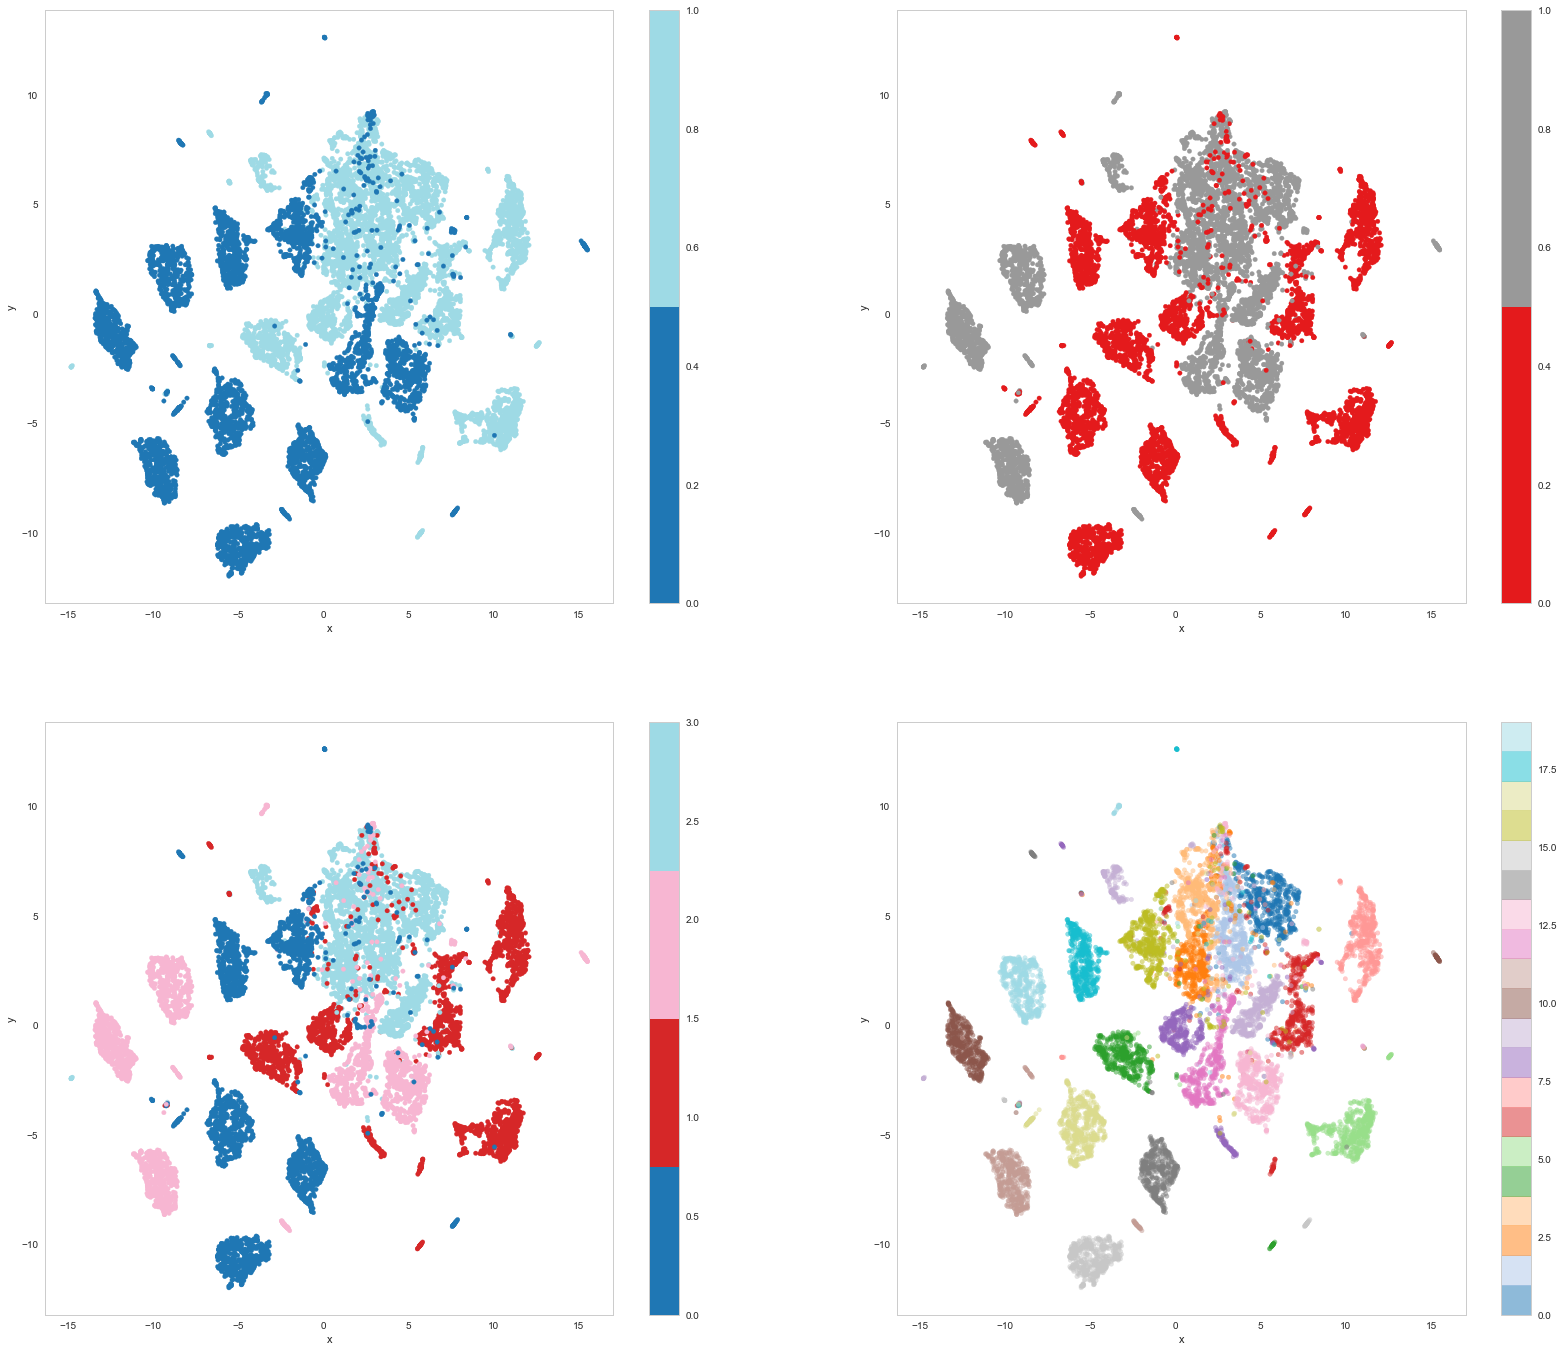

In [64]:
plot_embedding(umap_lev_25_minkowski)

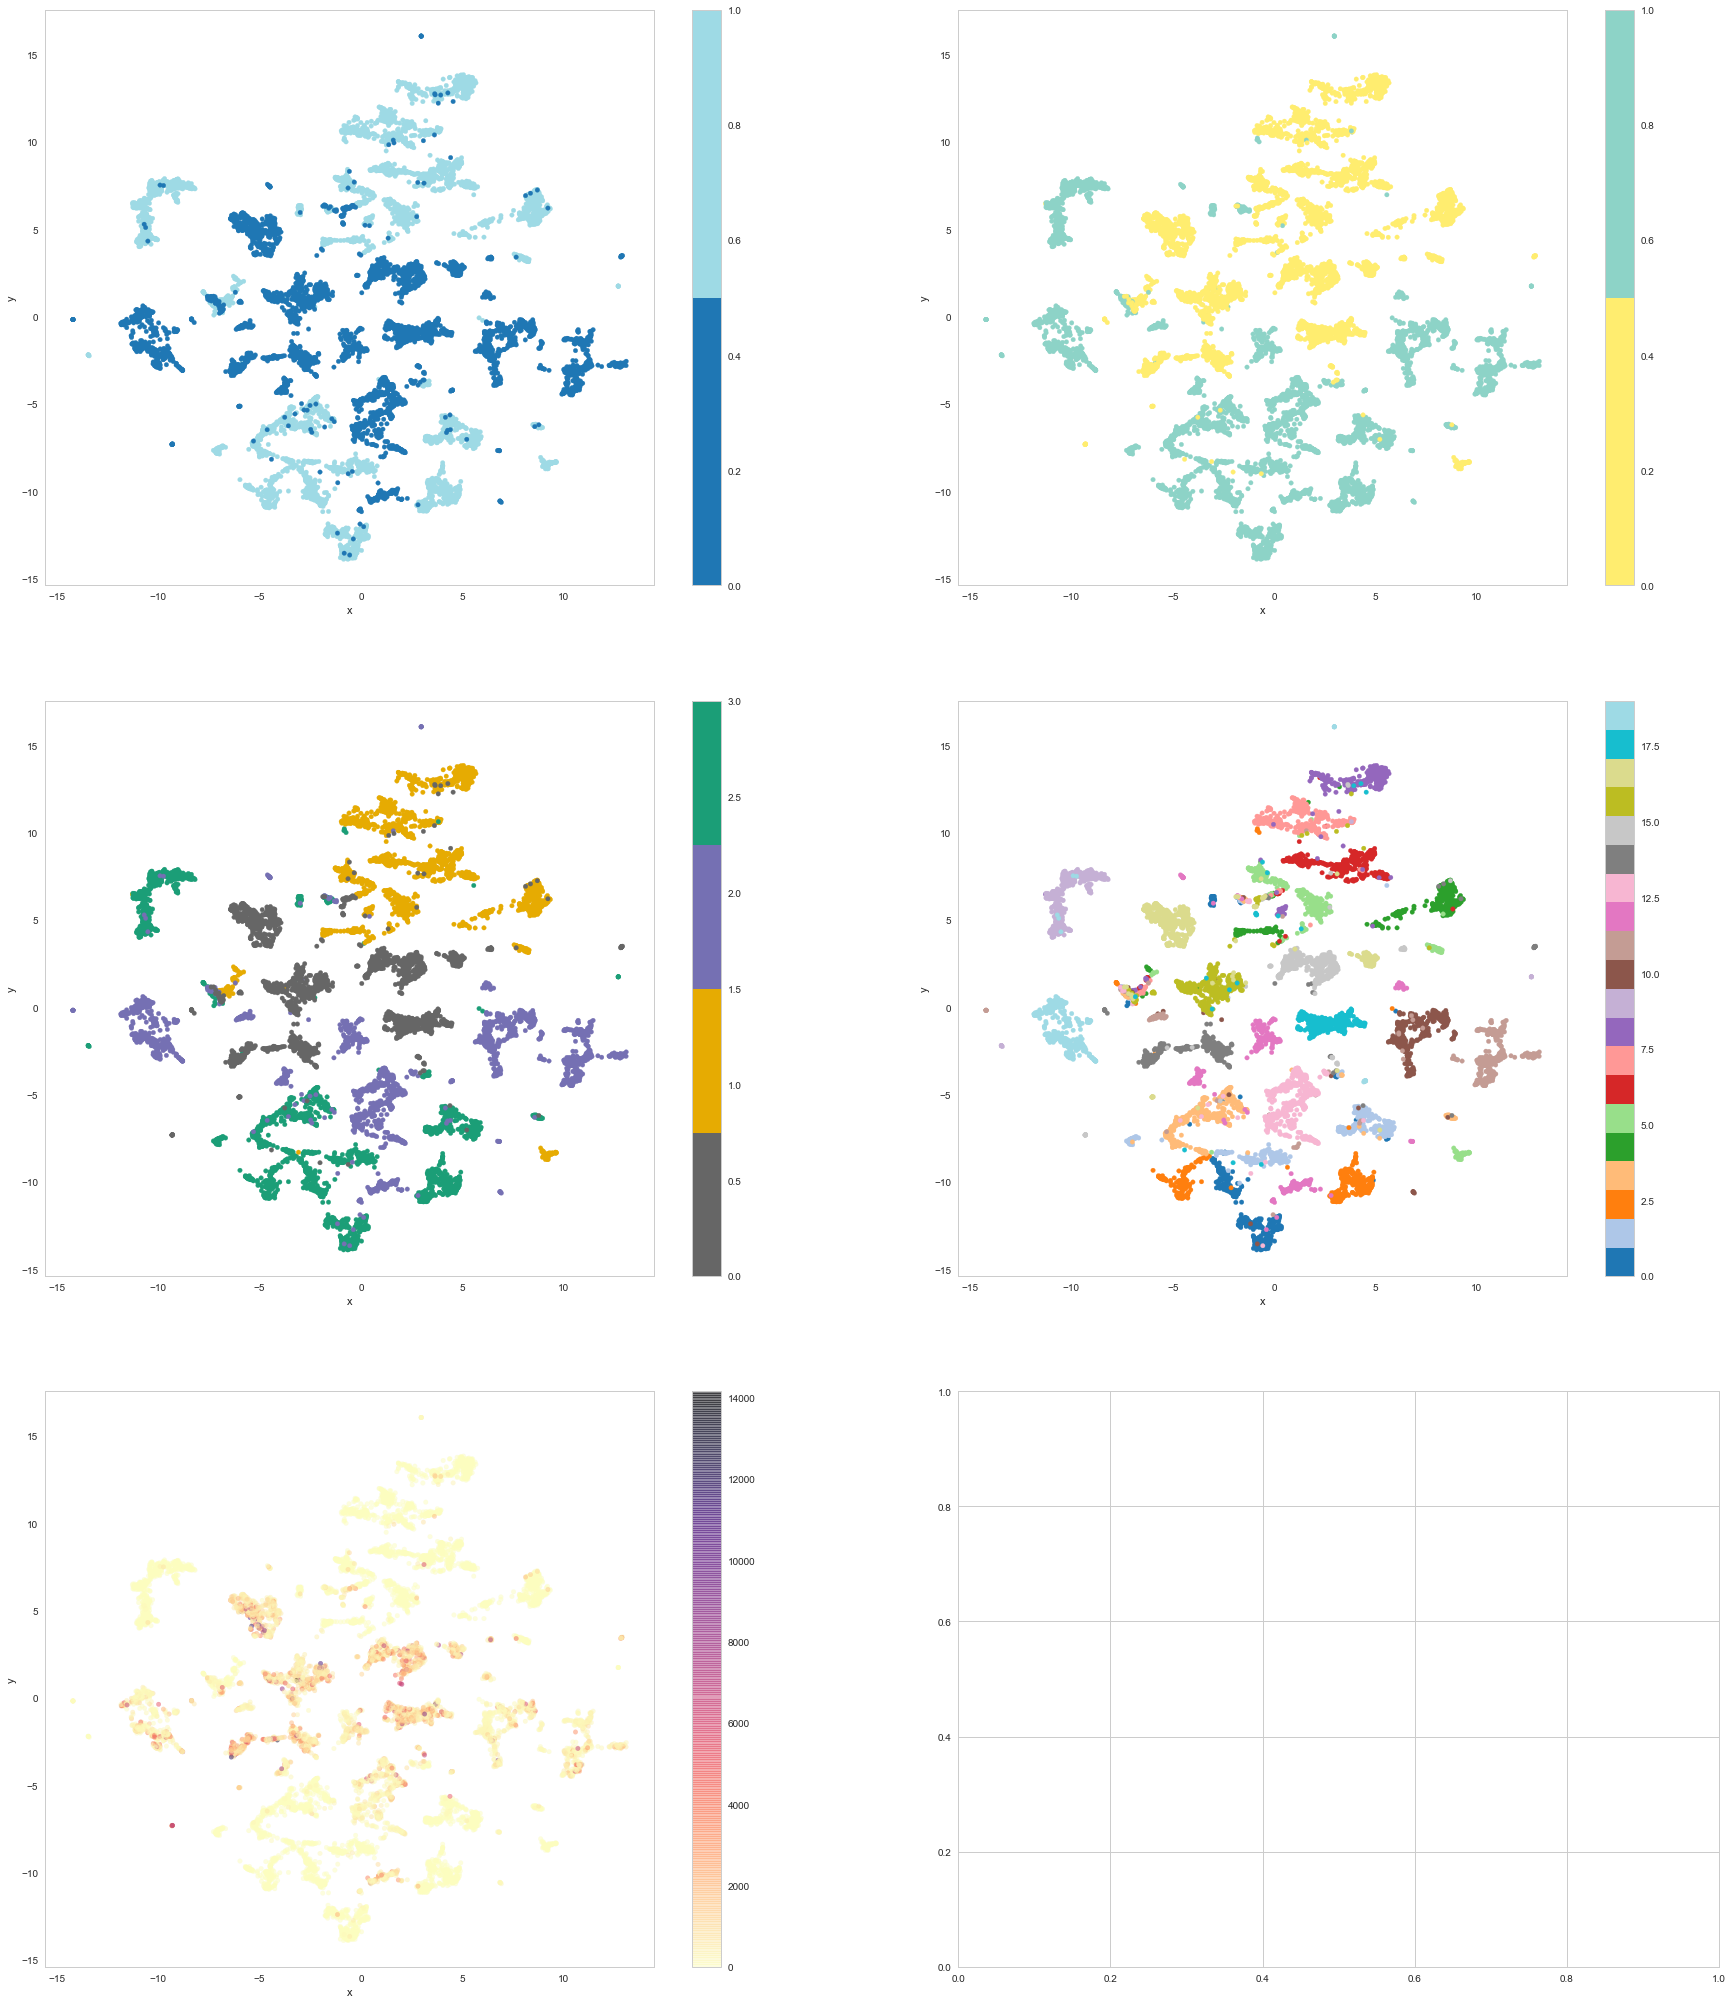

In [73]:
plot_embedding(umap_lev_500_minkowski)